# Import packages

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import scipy as sp
from scipy import interpolate
%matplotlib inline 

# Raw data files

In [ ]:
read_depth_file = 'read_depth_file_path' 

#brie output file direction where fractions.tsv files are located
raw_brie_file_location = 'brie_path'  

#categories of exons
exon_categories_ips = 'categories_path_ips'   
exon_categories_endo = 'categories_path_endo'

# single cell methylation data

#single cell methylation
methylation_of_cells = 'methylation_of_cells_path'   
methylation_of_cells_endo = 'methylation_of_cells_path_endo'   
#methylation of individual genes of cells
methylation_of_individual_genes = 'methylation_of_individual_genes_path' 

# Psi values
Psi_values_ips = 'Psi_ips_path'    
Psi_values_endo =  'Psi_endo_path' 
single_cell_Psi_ips = 'single_cell_Psi_ips_path'               

# list of multicell reads that have to be removed from data
drop_list_all = ["20287_7.1", "20287_7.8", "20287_8.1", "20287_8.8"]


# Splicing read depth iPS vs endo 

In [4]:
#just do the analysis on the cells that are also present in reads
df_reads=pd.read_csv(read_depth_file, sep=',', index_col=0) 
new_index_names = [entry.replace("#", ".") for entry in df_reads.columns]
df_reads.columns = new_index_names
df_reads = df_reads.drop(drop_list_all, axis=1)


In [5]:
dir_brie = raw_brie_file_location
covered_side= []
# total splice counts 
splice_count_dict = {}
for entry in os.listdir(dir_brie): 
     
    try:
        name = entry.split("_")[1] + "_" + entry.split("_")[2].split(".2")[0]
        if name in df_reads.columns:
            file_reads=dir_brie+entry+'/fractions.tsv'
            df_reads_curr=pd.read_csv(file_reads, sep='\t', skiprows=1, header=None )
            counts=df_reads_curr[3]
            counts=counts.astype(np.float)

            # get number of covered sites:
            covered_side.append(df_reads_curr[df_reads_curr[3]>0].shape[0])

            # generate dictionary that contains estimated number of splice events
            total_counts=(counts[1:].values+counts[:-1].values)
            splice_count_dict[name] = np.sum(total_counts)
    except:
        pass

In [7]:
read_vec_ips=[]
splice_vec_ips=[]
read_vec_endo=[]
splice_vec_endo=[]

for name in splice_count_dict.keys():
    try:
        if name[6]=='7': # iPS cells
            # devide by 1 millions to have nices axis
            read_vec_ips.append(df_reads[name].values[0]/1000000.)
            splice_vec_ips.append(splice_count_dict[name]/1000000.)
        elif name[6]=='8': # endoderm cells
            read_vec_endo.append(df_reads[name].values[0]/1000000.)
            splice_vec_endo.append(splice_count_dict[name]/1000000.)
    except:
        pass

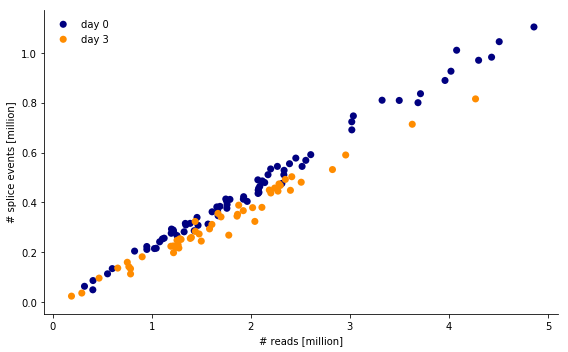

In [8]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)


ax.set_xlabel('# reads [million]' )
ax.set_ylabel('# splice events [million]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(read_vec_0, splice_vec_0, s=50, edgecolor='', c = 'navy', label="iPS")
ax.scatter(read_vec_3, splice_vec_3, s=50, edgecolor='', c = 'darkorange', label="endo")
plt.legend(loc="best", shadow=False, scatterpoints=1, frameon=False)



# Methylation distribution plot regions

In [9]:
# based on categories
cate = pd.read_csv(exon_categories_ips, index_col=0, header=None)
cate.columns = ["category"]
label_list_under_own=cate[cate["category"]=="underdispersed"].index

# load methylation of individual genes of cells
df_gene_meth=pd.read_csv(methylation_of_individual_genes, index_col=0)
df_gene_meth.index=[ entry.replace("#", ".") for entry in df_gene_meth.index]

# load Psi values
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
Psi_ips = Psi_ips.T
Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)
Psi_endo = Psi_endo.T

#load single cell methylation
single_cell_meth_dict = np.load(methylation_of_cells).item()

In [11]:
# comparison of the mean meth state
z_under_C1=[]
z_under_I1_5p=[]
z_under_I1_3p=[]
z_under_A=[]
z_under_I2_5p=[]
z_under_I2_3p=[]
z_under_C2=[]

under_list = [z_under_C1, z_under_I1_5p, z_under_I1_3p,z_under_A, z_under_I2_5p, z_under_I2_3p,  z_under_C2]

z_under_alt_C1=[]
z_under_alt_I1_5p=[]
z_under_alt_I1_3p=[]
z_under_alt_A=[]
z_under_alt_I2_5p=[]
z_under_alt_I2_3p=[]
z_under_alt_C2=[]

under_list_alt = [z_under_alt_C1, z_under_alt_I1_5p, z_under_alt_I1_3p,z_under_A, z_under_alt_I2_5p, z_under_alt_I2_3p,  z_under_alt_C2]
exon_list = ["C1", "I1_5p", "I1_3p", "A", "I2_5p", "I2_3p", "C2"]

for i in label_list_under_own: 
    name=i 
    m=0
    for curr_list in under_list:        
        under_list[m]=np.append(under_list[m], df_gene_meth[name].T[Psi_ips[name].dropna().index].values)
    
        for cell_name in Psi_ips[name].dropna().index:
            cell_name=cell_name.replace(".", "#")
            under_list_alt[m]=np.append(under_list_alt[m],single_cell_meth_dict[cell_name].T[name][exon_list[m]] )
        m+=1

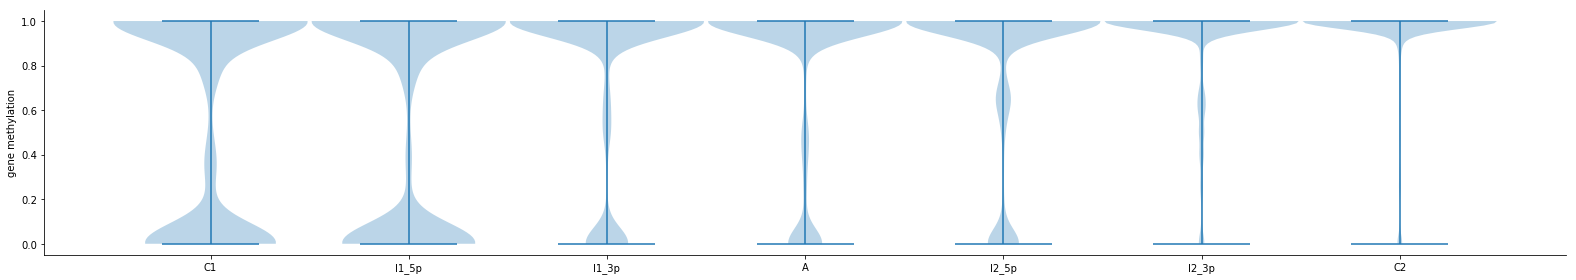

In [12]:
f, ax = plt.subplots( figsize=(22,4))
ax.set_ylabel("gene methylation")



ax.set_xticklabels(["0", "C1", "I1_5p", "I1_3p", "A", "I2_5p", "I2_3p", "C2"])

ax.violinplot(under_list_alt, widths=0.98)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Heatmap methylation difference change category iPS and endo

In [ ]:
# get methylation difference between iPS and endo
def get_meth_difference(name):
    z_ips = []
    z_endo = []
    # get distribution for iPS
    for cell_name in Psi_ips[name].dropna().index:      
        z_ips=np.append(z_ips, df_gene_meth[name].T[Psi_ips[name].dropna().index][cell_name])
    
    # get distribution for endo
    for cell_name in Psi_endo[name].dropna().index:      
        z_endo=np.append(z_endo, df_gene_meth[name].T[Psi_endo[name].dropna().index][cell_name])
    
    # return both distributions 
    return z_ips, z_endo
    

In [48]:

def estimate_q(pv, m=None, verbose=False, lowmem=False, pi0=None):
    """
    Estimates q-values from p-values
    Args
    =====
    m: number of tests. If not specified m = pv.size
    verbose: print verbose messages? (default False)
    lowmem: use memory-efficient in-place algorithm
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
         For most GWAS this is not necessary, since pi0 is extremely likely to be
         1
    """
    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    if m is None:
        m = float(len(pv))
    else:
        # the user has supplied an m
        m *= 1.0

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = sp.arange(0, 0.90, 0.01)
        counts = sp.array([(pv > i).sum() for i in sp.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = sp.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)
        if verbose:
            print("qvalues pi0=%.3f, estimated proportion of null features " % pi0)

        if pi0 > 1:
            if verbose:
                print("got pi0 > 1 (%.3f) while estimating qvalues, setting it to 1" % pi0)
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    if lowmem:
        # low memory version, only uses 1 pv and 1 qv matrices
        qv = sp.zeros((len(pv),))
        last_pv = pv.argmax()
        qv[last_pv] = (pi0*pv[last_pv]*m)/float(m)
        pv[last_pv] = -sp.inf
        prev_qv = last_pv
        for i in xrange(int(len(pv))-2, -1, -1):
            cur_max = pv.argmax()
            qv_i = (pi0*m*pv[cur_max]/float(i+1))
            pv[cur_max] = -sp.inf
            qv_i1 = prev_qv
            qv[cur_max] = min(qv_i, qv_i1)
            prev_qv = qv[cur_max]

    else:
        p_ordered = sp.argsort(pv)
        pv = pv[p_ordered]
        qv = pi0 * m/len(pv) * pv
        qv[-1] = min(qv[-1], 1.0)

        for i in xrange(len(pv)-2, -1, -1):
            qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

        # reorder qvalues
        qv_temp = qv.copy()
        qv = sp.zeros_like(qv)
        qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv

In [18]:
# based on categories
cate = pd.read_csv(exon_categories_ips, index_col=0, header=None)
cate.columns = ["category"]
label_list_over_own=cate[cate["category"]=="overdispersed"].index
label_list_under_own=cate[cate["category"]=="underdispersed"].index
label_list_in_own=cate[cate["category"]=="included"].index
label_list_ex_own=cate[cate["category"]=="excluded"].index
label_list_mult_own=cate[cate["category"]=="multimodal"].index


# based on categories
cate_endo = pd.read_csv(exon_categories_endo, index_col=0, header=None)
label_list_over_own_endo=cate_endo[cate_endo["category"]=="overdispersed"].index
label_list_under_own_endo=cate_endo[cate_endo["category"]=="underdispersed"].index
label_list_in_own_endo=cate_endo[cate_endo["category"]=="included"].index
label_list_ex_own_endo=cate_endo[cate_endo["category"]=="excluded"].index
label_list_mult_own_endo=cate_endo[cate_endo["category"]=="multimodal"].index

# look for genes that change from over to underdispersed
poss_day_endo = [label_list_over_own_endo, label_list_under_own_endo, label_list_in_own_endo, label_list_ex_own_endo, label_list_mult_own_endo  ]
poss_day_endo_name = ['over_endo', 'under_endo', 'in_endo', 'ex_endo', 'mult_endo']
poss_day_ips = [label_list_over_own, label_list_under_own, label_list_in_own, label_list_ex_own, label_list_mult_own  ]
poss_day_ips_name = ['over_ips', 'under_ips', 'in_ips', 'ex_ips', 'mult_ips']

transfer_dict = {}

for n in range(len(poss_day_endo)):
    for m in range(len(poss_day_ips)):
        # set new list for each new combination
        curr_list = []   
        for entry in poss_day_endo[n]:
            if entry in poss_day_ips[m]:
                curr_list.append(entry)
            # at the end write in dict
            transfer_dict[(poss_day_ips_name[m] + "_to_" + poss_day_endo_name[n]) ] = curr_list

In [19]:
# Make df_delta only for one day

# load Psi values
Psi_ips = pd.read_csv(Psi_values_ips, index_col=0)
Psi_ips = Psi_ips.T
Psi_endo = pd.read_csv(Psi_values_endo, index_col=0)
Psi_endo = Psi_endo.T

#load single cell methylation
#load single cell methylation
single_cell_meth_dict = np.load(methylation_of_cells).item()
single_cell_meth_dict_endo = np.load(methylation_of_cells_endo).item()
# load methylation of individual genes of cells
df_gene_meth=pd.read_csv(methylation_of_individual_genes, index_col=0)
df_gene_meth.index=[ entry.replace("#", ".") for entry in df_gene_meth.index]

In [ ]:
# get table with mean meth of iPS and endo
mean_meth_dict = {}
for title in transfer_dict:
    z_ips_total = []
    z_endo_total = []
    for gene_name in transfer_dict[title]:
        z_ips, z_endo = get_meth_difference(gene_name)
        z_ips_total = z_ips_total + list(z_ips)
        z_endo_total = z_endo_total + list(z_endo)
    try:        
        z_ips_total = [value for value in z_ips_total if not math.isnan(value)]
        
        z_endo_total = [value for value in z_endo_total if not math.isnan(value)]
        
        
        # make tests
        # t test
        t_test = stats.ttest_ind(z_ips_total, z_endo_total)[1]
        wilcoxn_ranksum = stats.ranksums(z_ips_total, z_endo_total)[1]
        
        z_ips_mean = np.mean(z_ips_total)
        z_endo_mean = np.mean(z_endo_total)

        
        # write to table 
        try:
            
            mean_meth_dict["iPS"].append(z_ips_mean) 
            mean_meth_dict["endo"].append(z_endo_mean)
            mean_meth_dict["ttest_ind"].append(t_test) 
            mean_meth_dict["wilcoxn_ranksum"].append(wilcoxn_ranksum)
        except:
            # when run the first time 
            mean_meth_dict["iPS"] = [z_ips_mean]
            mean_meth_dict["endo"] = [z_endo_mean]
            mean_meth_dict["ttest_ind"] = [t_test]
            mean_meth_dict["wilcoxn_ranksum"] = [wilcoxn_ranksum]
        
    except:
        pass
    
    

In [ ]:
compare_meth_df = pd.DataFrame.from_dict(mean_meth_dict)
title_list = []
for title in transfer_dict:
    title_list.append(title)
compare_meth_df.index = title_list

In [54]:
y_name = ["in_to_mult", "in_to_over", "in_to_under", "in_to_in", "ex_to_mult", "ex_to_over", "ex_to_ex", "mult_to_mult", "mult_to_over", "mult_to_under", "mult_to_in" , "mult_to_ex", "over_to_mult", "over_to_over", "over_to_in", "over_to_ex", "under_to_mult", "under_to_over", "under_to_under", "under_to_in", "under_to_ex"]   

is_significant_list = []
methylation_difference_list = []
methylation_day_ips_list = []
methylation_day_endo_list = []

m=0
for name in y_name:
    new_name = name.split("_")[0] + "_ips_to_" + name.split("_")[2]  + "_endo"
    meth_day_ips = compare_meth_df.T[new_name]["iPS"]
    meth_day_endo = compare_meth_df.T[new_name]["endo"]
    diff_meth = meth_day_endo - meth_day_ips
    is_significant = compare_meth_df.T[new_name]["wilcoxn_ranksum"] <= 0.05
    is_significant_list.append(is_significant)
    methylation_difference_list.append(diff_meth)
    methylation_day_ips_list.append(meth_day_ips)
    methylation_day_endo_list.append(meth_day_endo)

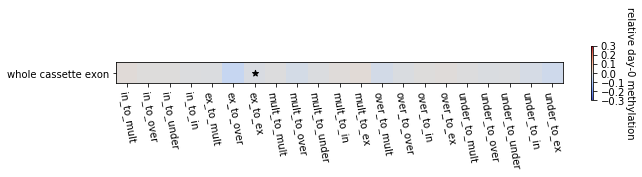

In [56]:
# vertical
lables2 = [ "whole cassette exon"]
# as heatmap with methylation difference 
a = np.array([methylation_difference_list])
y_name = ["in_to_mult", "in_to_over", "in_to_under", "in_to_in", "ex_to_mult", "ex_to_over", "ex_to_ex", "mult_to_mult", "mult_to_over", "mult_to_under", "mult_to_in" , "mult_to_ex", "over_to_mult", "over_to_over",  "over_to_in", "over_to_ex", "under_to_mult", "under_to_over", "under_to_under", "under_to_in", "under_to_ex"]   
fig = plt.figure(figsize=(10, 1))
ax= plt.subplot(111) 
plt.imshow(a, cmap='coolwarm', vmin=-0.3, vmax=0.3)
ax.set_xticks(range(22))
ax.set_yticks(range(1))

ax.set_xticklabels(y_name, rotation=-80)
ax.set_yticklabels(lables2)
cbar = plt.colorbar()
cbar.set_label("relative iPS methylation", rotation=-90, labelpad=10)

m=0
for significant in is_significant_list:
    if significant:
        ax.scatter(m, 0, marker='*', s=40, color='black')
        
    m+=1
        